## TP3: Reconnaissance de signaux de communication par apprentissage profond

Students:
- Mathilde Dupouy
- Balthazar Neveu

In [70]:
# %general imports
from data_loader import get_data, SignalsDataset, SAMPLE_DATA_PATH

from visualization import visualize_signals, visualize_two_signals
from random import randint
interactive_flag = True
try:
    from ipywidgets import interact, IntSlider, fixed
    interactive_flag *= True
except:
    interactive_flag = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loader
@TODO: comment on data, label_dict

In [68]:
# % data loading from disk
signals, snr, labels_id, label_dict = get_data()
data_in = [signals, snr, labels_id, label_dict]

(200, 2048, 2)

In [51]:
# % interactive visualization
data_in = [signals, snr, labels_id, label_dict]
if interactive_flag:
    interact(
        visualize_signals,
        data_in = fixed(data_in),
        idx=IntSlider(min=0, max=signals.shape[0]-1, step=1))
else:
    for idx in range(5):
        visualize_signals(data_in = data_in, idx=randint(0, signals.shape[0]-1))

interactive(children=(IntSlider(value=0, description='idx', max=199), Output()), _dom_classes=('widget-interac…

In [101]:
from data_loader import preprocessing

# % interactive visualization
signals_1, snr_1, labels_id_1, label_dict_1 = get_data(SAMPLE_DATA_PATH)
data_1 = [signals_1, snr_1, labels_id_1, label_dict_1]
signals_2, snr_2, labels_id_2, label_dict_2 = preprocessing(SAMPLE_DATA_PATH)
data_2 = [signals_2, snr_2, labels_id_2, label_dict_2]
if interactive_flag:
    interact(
        visualize_two_signals,
        data_1 = fixed(data_1),
        data_2 = fixed(data_2),
        idx=IntSlider(min=0, max=signals.shape[0]-1, step=1))
else:
    for idx in range(5):
        visualize_two_signals(data_1 = data_1, data_2 = data_2, idx=randint(0, signals.shape[0]-1))

interactive(children=(IntSlider(value=0, description='idx', max=199), Output()), _dom_classes=('widget-interac…

In [31]:
# % check toy dataloader
from data_loader import get_data, SignalsDataset, SAMPLE_DATA_PATH
from torch.utils.data import DataLoader
N = 8  # batch size
C = 2 # number of channels
T = 2048 # signal length


dataset = SignalsDataset(SAMPLE_DATA_PATH)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
batch_signal, batch_labels = next(iter(train_dataloader))
assert batch_signal.shape == (N, C, T) # A batch shall be a 8, 2, 2048 tensor

## Vanilla classifier

In [36]:
from model import VanillaClassifier
%load_ext autoreload
%autoreload 2

device = "cpu"
model = VanillaClassifier()
def sanity_check():
# model.to(device)
# Sanity check on inference
    pred = model(batch_signal)
    print(pred.shape, batch_labels.shape)
    import torch
    loss = torch.nn.CrossEntropyLoss()
    loss(pred, batch_labels[:, 0])
sanity_check()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([8, 7]) torch.Size([8, 1])


In [37]:
from training import train
from data_loader import get_dataloaders
dataloaders = get_dataloaders()



In [38]:
import torch
torch.cuda.is_available()

False

In [41]:
device = "cpu"
from training import train
from model import VanillaClassifier
model = VanillaClassifier()
model, training_losses, valid_losses, valid_accuracies  = train(model, batch_sizes=(256, 512), device=device, n_epochs=50)

Epoch 0: 100%|██████████| 118/118 [00:09<00:00, 12.36it/s]
c:\Users\mathi\OneDrive\Documents\GitHub\MVA23_SIGNAL\lab_03\training.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = torch.nn.Softmax()(prediction)


epoch=0 | training_loss=1.907 | valid_loss=1.89 | 16.75%


Epoch 1: 100%|██████████| 118/118 [00:11<00:00, 10.23it/s]


epoch=1 | training_loss=1.865 | valid_loss=1.84 | 16.45%


Epoch 2: 100%|██████████| 118/118 [00:12<00:00,  9.50it/s]


epoch=2 | training_loss=1.825 | valid_loss=1.81 | 16.33%


Epoch 3: 100%|██████████| 118/118 [00:12<00:00,  9.20it/s]


epoch=3 | training_loss=1.804 | valid_loss=1.8 | 16.33%


Epoch 4: 100%|██████████| 118/118 [00:14<00:00,  8.22it/s]


epoch=4 | training_loss=1.794 | valid_loss=1.79 | 17.93%


Epoch 5: 100%|██████████| 118/118 [00:17<00:00,  6.78it/s]


epoch=5 | training_loss=1.788 | valid_loss=1.79 | 19.31%


Epoch 6: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


epoch=6 | training_loss=1.782 | valid_loss=1.78 | 17.88%


Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


epoch=7 | training_loss=1.777 | valid_loss=1.78 | 20.36%


Epoch 8: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]


epoch=8 | training_loss=1.771 | valid_loss=1.77 | 17.78%


Epoch 9: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


epoch=9 | training_loss=1.765 | valid_loss=1.76 | 18.21%


Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


epoch=10 | training_loss=1.757 | valid_loss=1.75 | 24.51%


Epoch 11: 100%|██████████| 118/118 [00:16<00:00,  6.95it/s]


epoch=11 | training_loss=1.747 | valid_loss=1.74 | 28.45%


Epoch 12: 100%|██████████| 118/118 [00:17<00:00,  6.59it/s]


epoch=12 | training_loss=1.736 | valid_loss=1.73 | 24.62%


Epoch 13: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


epoch=13 | training_loss=1.720 | valid_loss=1.71 | 25.39%


Epoch 14: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


epoch=14 | training_loss=1.700 | valid_loss=1.69 | 26.20%


Epoch 15: 100%|██████████| 118/118 [00:18<00:00,  6.38it/s]


epoch=15 | training_loss=1.675 | valid_loss=1.66 | 28.85%


Epoch 16: 100%|██████████| 118/118 [00:17<00:00,  6.76it/s]


epoch=16 | training_loss=1.645 | valid_loss=1.63 | 32.88%


Epoch 17: 100%|██████████| 118/118 [00:18<00:00,  6.43it/s]


epoch=17 | training_loss=1.607 | valid_loss=1.59 | 32.72%


Epoch 18: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


epoch=18 | training_loss=1.565 | valid_loss=1.54 | 33.25%


Epoch 19: 100%|██████████| 118/118 [00:27<00:00,  4.36it/s]


epoch=19 | training_loss=1.519 | valid_loss=1.49 | 32.55%


Epoch 20: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


epoch=20 | training_loss=1.470 | valid_loss=1.44 | 32.63%


Epoch 21: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


epoch=21 | training_loss=1.423 | valid_loss=1.4 | 33.83%


Epoch 22: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


epoch=22 | training_loss=1.379 | valid_loss=1.36 | 32.97%


Epoch 23: 100%|██████████| 118/118 [00:19<00:00,  6.20it/s]


epoch=23 | training_loss=1.341 | valid_loss=1.32 | 32.13%


Epoch 24: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


epoch=24 | training_loss=1.309 | valid_loss=1.29 | 32.66%


Epoch 25: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


epoch=25 | training_loss=1.283 | valid_loss=1.27 | 33.00%


Epoch 26: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


epoch=26 | training_loss=1.262 | valid_loss=1.25 | 34.13%


Epoch 27:  23%|██▎       | 27/118 [00:05<00:18,  4.79it/s]


KeyboardInterrupt: 

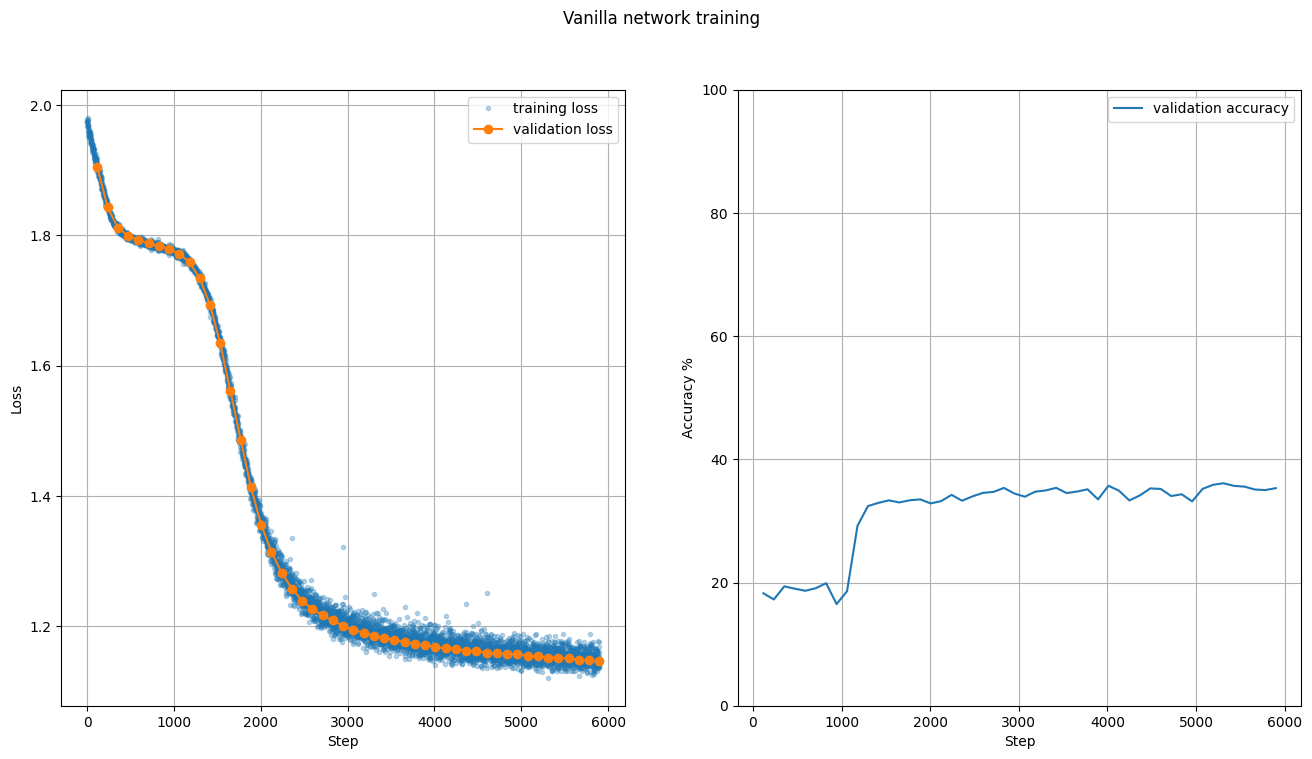

In [4]:
import matplotlib.pyplot as plt
import numpy as np
epoch_length = len(training_losses)/len(valid_losses)
epoch_steps = np.linspace(epoch_length, len(training_losses), len(valid_losses)) 

fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].plot(training_losses, ".", alpha=0.3, label="training loss")

axs[0].plot(epoch_steps, valid_losses,  "-o", label="validation loss")

axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].plot(epoch_steps, 100*np.array(valid_accuracies),  "-", label="validation accuracy")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Accuracy %")
axs[1].legend()
axs[1].grid()
axs[1].set_ylim(0, 100)
plt.suptitle("Vanilla network training")
plt.show()